In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from neo4j import GraphDatabase
from dotenv import load_dotenv
from firecrawl_scraping import *
from utility import *
from llm_extraction import *
from tqdm import tqdm
import glob
import tiktoken


/Users/chenkangan/Documents/UCL DSML/Thesis/project/ucl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### PitchBook Data Preprocessing

In [2]:
# Sanitize property names
def process_column_name(name):
    name = name.lower()
    return name.replace(' ', '_').replace('#', 'number').replace('/', '_').replace(';', '_').replace('-', '_').replace(',', '')
    
def preprocess_url(url):
    # Check for NaN (missing URL)
    if isinstance(url, float):
        return None

    # Ensure the URL has 'http://' or 'https://' at the start
    if not url.startswith('www.'):
        url = 'www.' + url
    
    return url

In [3]:
df = pd.read_excel('data/PitchBook_All_Columns_2024_07_04_14_48_36.xlsx', header=8)
len(list(df.columns))

175

In [4]:
columns_of_interest = ['Company ID','Companies','Company Former Name','Company Legal Name','Competitors',
 'Description','Primary Industry Sector','Primary Industry Group','Primary Industry Code','All Industries','Verticals',
 'Keywords', 'Company Financing Status','Total Raised','Business Status','Ownership Status','Universe','Website', 'Employees',
 'Year Founded','Parent Company','Market Cap', 'Revenue','Gross Profit','Net Income','Enterprise Value','HQ Location', 'HQ Country/Territory/Region',
 'HQ City', 'HQ State/Province','HQ Global Region','HQ Global Sub Region','Active Investors','# Active Investors','Acquirers','IPO Probability','M&A Probability',
 'First Financing Valuation', 'First Financing Valuation Status','Last Financing Valuation','Last Financing Valuation Status', 
 'Last Known Valuation','Last Known Valuation Date','Last Known Valuation Deal Type'
]

df = df[columns_of_interest]
df = df[~df['Company ID'].isna()]
processed_column_names = [process_column_name(i) for i in columns_of_interest]
column_mapper = dict(zip(columns_of_interest, processed_column_names))
df = df.rename(column_mapper, axis=1)
df['processed_url'] = df['website'].apply(preprocess_url)
df = df.dropna(subset=['processed_url'])
df = df[~df['business_status'].isin(['Out of Business', 'Bankruptcy: Liquidation', 'Bankruptcy: Admin/Reorg'])]

df.head()

,company_id,companies,company_former_name,company_legal_name,competitors,description,primary_industry_sector,primary_industry_group,primary_industry_code,all_industries,...,ipo_probability,m&a_probability,first_financing_valuation,first_financing_valuation_status,last_financing_valuation,last_financing_valuation_status,last_known_valuation,last_known_valuation_date,last_known_valuation_deal_type,processed_url
0,55185-04,Estimize,NaN,"Estimize, Inc.","Neudata, SigFig, Motif (Financial Software), Y...",Developer of an open financial estimates platf...,Information Technology,Software,Financial Software,"Financial Software*, Media and Information Ser...",...,NaN,NaN,6.34,Actual,NaN,NaN,36.00,2015-07-16,Early Stage VC,www.estimize.com
2,56288-62,New Constructs,NaN,"New Constructs, LLC","Morningstar, CFRA, Finbox (Media and Informati...",Operator of an investment research firm intend...,Information Technology,Software,Financial Software,"Financial Software*, Media and Information Ser...",...,NaN,NaN,2.17,Actual,NaN,NaN,2.17,2003-05-13,Early Stage VC,www.newconstructs.com
3,59990-50,Justworks,Clockwork,"Justworks, Inc.","UKG, Personio, Zenefits, Namely, Flock (Busine...",Developer of a human resource management platf...,Information Technology,Software,Business/Productivity Software,"Business/Productivity Software*, Human Capital...",...,33.0,52.0,NaN,NaN,NaN,NaN,1950.00,2020-01-28,Later Stage VC,www.justworks.com
4,53739-01,Procore Technologies (NYS: PCOR),NaN,"Procore Technologies, Inc.","Projectmates, eBuilder, CMiC",Procore Technologies Inc is a cloud-based cons...,Information Technology,Software,Business/Productivity Software,"Business/Productivity Software*, Construction ...",...,NaN,NaN,4.00,Actual,8585.03,Estimated,8585.03,2021-05-20,IPO,www.procore.com
5,58716-37,Driveway (Business/Productivity Software),NaN,Driveway Software Corporation,"Viaduct (Business/Productivity Software), Tour...",Developer of a telematics technology designed ...,Information Technology,Software,Business/Productivity Software,"Business/Productivity Software*, Media and Inf...",...,NaN,NaN,NaN,NaN,NaN,NaN,51.10,2015-07-28,Early Stage VC,www.driveway.ai


### Exploratory Analysis

In [6]:
df1 = pd.read_csv('data/PitchBook_All_Columns_2024_07_04_14_48_36_accessibility.csv')
print(df1.business_status.unique())
df1 = df1[~df1['business_status'].isin(['Out of Business', 'Bankruptcy: Liquidation', 'Bankruptcy: Admin/Reorg'])]
df1['companies'] = df1['companies'].str.replace(r'\s*\(.*?\)\s*', '', regex=True)

df = df1.copy()

# Convert last_known_valuation to numeric, if not already
# First, ensure that 'last_known_valuation' is in the correct numeric format
df['last_known_valuation'] = pd.to_numeric(df['last_known_valuation'], errors='coerce')

# Apply the filter to create a new DataFrame
filtered_df = df[(df['last_known_valuation'].isna()) | (df['last_known_valuation'] < 500)]

# Now, 'filtered_df' contains only the rows where the valuation is NaN or less than 500 million
filtered_df = filtered_df[filtered_df['is_accessible'] == True]

filtered_df.head()

['Generating Revenue' 'Profitable' 'Generating Revenue/Not Profitable'
 'Startup' 'Stealth' 'Product In Beta Test' 'Clinical Trials - Phase 1'
 'Restart']


,company_id,companies,company_former_name,company_legal_name,competitors,description,primary_industry_sector,primary_industry_group,primary_industry_code,all_industries,...,m&a_probability,first_financing_valuation,first_financing_valuation_status,last_financing_valuation,last_financing_valuation_status,last_known_valuation,last_known_valuation_date,last_known_valuation_deal_type,processed_url,is_accessible
0,55185-04,Estimize,NaN,"Estimize, Inc.","Neudata, SigFig, Motif (Financial Software), Y...",Developer of an open financial estimates platf...,Information Technology,Software,Financial Software,"Financial Software*, Media and Information Ser...",...,NaN,6.34,Actual,NaN,NaN,36.00,16/07/2015,Early Stage VC,www.estimize.com,True
1,56288-62,New Constructs,NaN,"New Constructs, LLC","Morningstar, CFRA, Finbox (Media and Informati...",Operator of an investment research firm intend...,Information Technology,Software,Financial Software,"Financial Software*, Media and Information Ser...",...,NaN,2.17,Actual,NaN,NaN,2.17,13/05/2003,Early Stage VC,www.newconstructs.com,True
10,58565-08,RealScout,NaN,"RealScout, Inc.","Spark (Business/Productivity Software), Proper...",The company's platform combines buyer data-dri...,Information Technology,Software,Business/Productivity Software,"Business/Productivity Software*, Media and Inf...",...,NaN,15.41,Actual,NaN,NaN,32.60,17/10/2016,Early Stage VC,www.realscout.com,True
13,50851-45,Cardlytics,NaN,Cardlytics Inc.,"Smaato, Clutch (Pennsylvania), NextRoll, Path,...",Cardlytics Inc operates an advertising platfor...,Business Products and Services (B2B),Commercial Services,Media and Information Services (B2B),"Business/Productivity Software, Media and Info...",...,NaN,4.25,Actual,253.76,Actual,253.76,09/02/2018,IPO,www.cardlytics.com,True
19,166942-18,Hemlane,NaN,"Hemlane, Inc.","VTS, CompStak, Lavanda, Bixby, Tenant Turner, ...",Developer of a property rental management plat...,Business Products and Services (B2B),Commercial Services,Media and Information Services (B2B),"Business/Productivity Software, Media and Info...",...,72.0,NaN,NaN,NaN,NaN,39.00,29/10/2021,Later Stage VC,www.hemlane.com,True


In [7]:
df_url = pd.read_csv('data/companies_urls_info.csv').rename({'company':'companies'}, axis = 1)
df_url

,companies,processed_name,url,related_urls_str,related_urls,num_of_related_urls,all_urls,num_of_all_urls
0,ValidiFI,validifi,https://www.validifi.com,https://www.validifi.com,['https://www.validifi.com'],1,"['https://www.validifi.com#content', 'https://...",2.0
1,Revvin,revvin,https://www.revvin.com,https://www.revvin.com,['https://www.revvin.com'],1,['https://www.revvin.com'],1.0
2,GOTYOU,gotyou,https://www.gotyou.co,https://www.gotyou.co,['https://www.gotyou.co'],1,"['https://www.gotyou.co#content', 'https://www...",6.0
3,Credenza,credenza,https://www.credenza3.com,https://www.credenza3.com/solutions-for/analyt...,['https://www.credenza3.com/solutions-for/anal...,7,['https://www.credenza3.com/solutions-for/anal...,14.0
4,Concerto,concerto,https://www.concertocard.com,https://www.concertocard.com/partnerships.html...,['https://www.concertocard.com/partnerships.ht...,2,"['https://www.concertocard.com/privacy.html', ...",7.0
...,...,...,...,...,...,...,...,...
786,Fyxt,fyxt,https://www.fyxt.com,https://www.fyxt.com,['https://www.fyxt.com'],1,"['https://www.fyxt.com#foot_sign_up_form_sec',...",2.0
787,Megalytics,megalytics,https://www.megalytics.net,https://www.megalytics.net,['https://www.megalytics.net'],1,"['https://www.megalytics.net', 'https://www.me...",2.0
788,Kalder,kalder,https://www.kalder.app,"https://www.kalder.app/customers,https://www.k...","['https://www.kalder.app/customers', 'https://...",2,"['https://www.kalder.app/', 'https://www.kalde...",2.0
789,Vyzer,vyzer,https://www.vyzer.co,https://www.vyzer.co,['https://www.vyzer.co'],1,['https://www.vyzer.co#testimonial_Carousel'],1.0


In [9]:
df_merge = filtered_df.merge(df_url, how = 'inner', on = 'companies')
df_merge[df_merge['last_known_valuation_deal_type'] == 'IPO']

,company_id,companies,company_former_name,company_legal_name,competitors,description,primary_industry_sector,primary_industry_group,primary_industry_code,all_industries,...,last_known_valuation_deal_type,processed_url,is_accessible,processed_name,url,related_urls_str,related_urls,num_of_related_urls,all_urls,num_of_all_urls
3,50851-45,Cardlytics,NaN,Cardlytics Inc.,"Smaato, Clutch (Pennsylvania), NextRoll, Path,...",Cardlytics Inc operates an advertising platfor...,Business Products and Services (B2B),Commercial Services,Media and Information Services (B2B),"Business/Productivity Software, Media and Info...",...,IPO,www.cardlytics.com,True,cardlytics,https://www.cardlytics.com,https://www.cardlytics.com/marketing-solutions...,['https://www.cardlytics.com/marketing-solutio...,7,"['https://www.cardlytics.com/patent', 'https:/...",25.0
124,115613-38,FPN,NaN,FPN Inc.,"6Sense, Venminder, CA Technologies, Yellow.ai,...",Operator of a data analytics platform intended...,Information Technology,Software,Business/Productivity Software,"Business/Productivity Software*, Media and Inf...",...,IPO,www.fraudprotectionnetwork.com,True,fpn,https://www.fraudprotectionnetwork.com,https://www.fraudprotectionnetwork.com?p=servi...,['https://www.fraudprotectionnetwork.com?p=ser...,2,['https://www.fraudprotectionnetwork.com?p=con...,6.0
776,155253-88,Way2vat,NaN,Way2vat Ltd.,"Finly (Financial Software), Basware, BuyerQues...",Way 2 Vat Ltd is a technology company providin...,Information Technology,Software,Financial Software,"Accounting, Audit and Tax Services (B2B), Fina...",...,IPO,www.way2vat.com,True,way2vat,https://www.way2vat.com,https://www.way2vat.com,['https://www.way2vat.com'],1,"['https://www.way2vat.com#tab1', 'https://www....",5.0


Note: The valuation column has a unit of $ in M

In [10]:
# Check for nulls and data types
print(df_merge[['last_known_valuation', 'last_known_valuation_deal_type']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   last_known_valuation            490 non-null    float64
 1   last_known_valuation_deal_type  490 non-null    object 
dtypes: float64(1), object(1)
memory usage: 12.5+ KB
None


In [11]:
# df_merge.to_csv('data/merge_url_companies.csv', index=False)

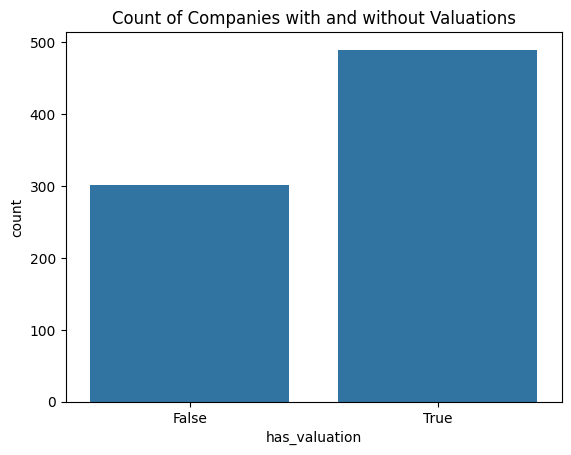

has_valuation
True     490
False    302
Name: count, dtype: int64

In [12]:
# Create a new column to identify whether valuation is present
df_merge['has_valuation'] = df_merge['last_known_valuation'].notna()

# Count plot
sns.countplot(x='has_valuation', data=df_merge)
plt.title('Count of Companies with and without Valuations')
plt.show()

df_merge['has_valuation'].value_counts()

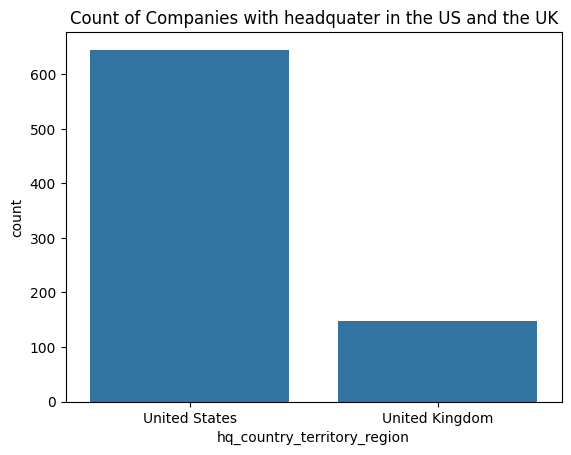

hq_country_territory_region
United States     645
United Kingdom    147
Name: count, dtype: int64

In [13]:
# Count plot
sns.countplot(x='hq_country_territory_region', data=df_merge)
plt.title('Count of Companies with headquater in the US and the UK')
plt.show()
df_merge['hq_country_territory_region'].value_counts()

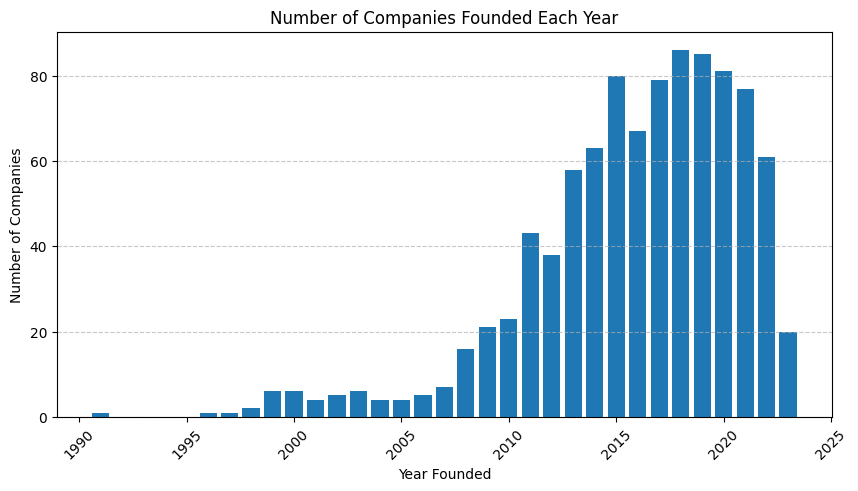

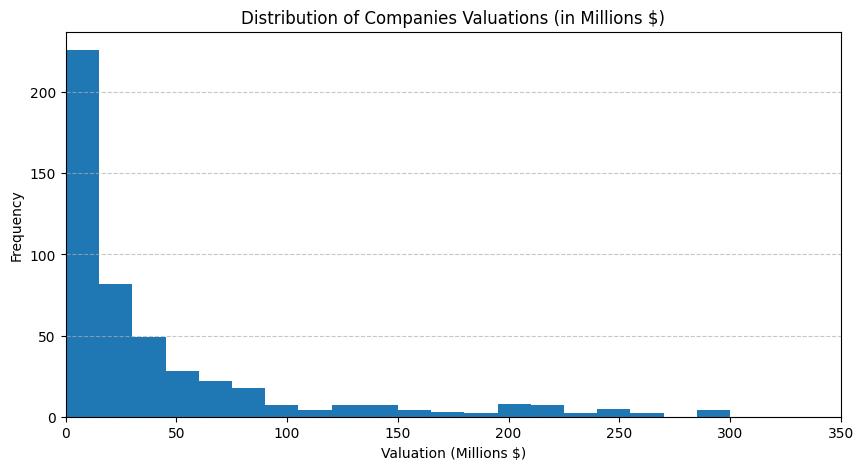

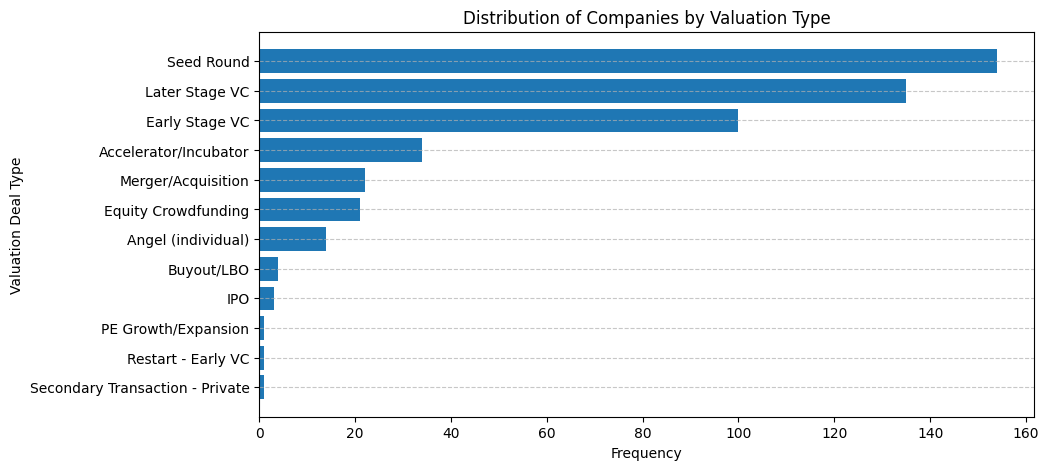

In [15]:
# Convert 'year_founded' to integer
df['year_founded'] = pd.to_numeric(df['year_founded'], errors='coerce')
df = df.dropna(subset=['year_founded'])
df['year_founded'] = df['year_founded'].astype(int)

# Count of companies per year
year_counts = df['year_founded'].value_counts().sort_index()

# Plotting with the first color of the current Seaborn palette
palette = sns.color_palette()  # Gets the current color palette from Seaborn
plt.figure(figsize=(10, 5))
plt.bar(year_counts.index, year_counts.values, color=palette[0])  # Using the first color in the palette
plt.title('Number of Companies Founded Each Year')
plt.xlabel('Year Founded')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

palette = sns.color_palette() 
# Filtering the DataFrame to include only entries with a valuation
data_with_valuation = df_merge[df_merge['last_known_valuation'].notna()]['last_known_valuation']

# Histogram plot
plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(data_with_valuation, bins=30, color=palette[0])
plt.title('Distribution of Companies Valuations (in Millions $)')
plt.xlabel('Valuation (Millions $)')
plt.ylabel('Frequency')
plt.xlim(0, 350)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Count of each valuation deal type
valuation_counts = df_merge['last_known_valuation_deal_type'].value_counts()

# Bar plot
plt.figure(figsize=(10, 5))
bars = plt.barh(valuation_counts.index[::-1], valuation_counts.values[::-1], color=palette[0])
plt.title('Distribution of Companies by Valuation Type')
plt.xlabel('Frequency')
plt.ylabel('Valuation Deal Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [18]:
filtered_df = filtered_df[filtered_df['is_accessible'] == True]
filtered_df.head()

,company_id,companies,company_former_name,company_legal_name,competitors,description,primary_industry_sector,primary_industry_group,primary_industry_code,all_industries,...,m&a_probability,first_financing_valuation,first_financing_valuation_status,last_financing_valuation,last_financing_valuation_status,last_known_valuation,last_known_valuation_date,last_known_valuation_deal_type,processed_url,is_accessible
0,55185-04,Estimize,NaN,"Estimize, Inc.","Neudata, SigFig, Motif (Financial Software), Y...",Developer of an open financial estimates platf...,Information Technology,Software,Financial Software,"Financial Software*, Media and Information Ser...",...,NaN,6.34,Actual,NaN,NaN,36.00,16/07/2015,Early Stage VC,www.estimize.com,True
1,56288-62,New Constructs,NaN,"New Constructs, LLC","Morningstar, CFRA, Finbox (Media and Informati...",Operator of an investment research firm intend...,Information Technology,Software,Financial Software,"Financial Software*, Media and Information Ser...",...,NaN,2.17,Actual,NaN,NaN,2.17,13/05/2003,Early Stage VC,www.newconstructs.com,True
10,58565-08,RealScout,NaN,"RealScout, Inc.","Spark (Business/Productivity Software), Proper...",The company's platform combines buyer data-dri...,Information Technology,Software,Business/Productivity Software,"Business/Productivity Software*, Media and Inf...",...,NaN,15.41,Actual,NaN,NaN,32.60,17/10/2016,Early Stage VC,www.realscout.com,True
13,50851-45,Cardlytics,NaN,Cardlytics Inc.,"Smaato, Clutch (Pennsylvania), NextRoll, Path,...",Cardlytics Inc operates an advertising platfor...,Business Products and Services (B2B),Commercial Services,Media and Information Services (B2B),"Business/Productivity Software, Media and Info...",...,NaN,4.25,Actual,253.76,Actual,253.76,09/02/2018,IPO,www.cardlytics.com,True
19,166942-18,Hemlane,NaN,"Hemlane, Inc.","VTS, CompStak, Lavanda, Bixby, Tenant Turner, ...",Developer of a property rental management plat...,Business Products and Services (B2B),Commercial Services,Media and Information Services (B2B),"Business/Productivity Software, Media and Info...",...,72.0,NaN,NaN,NaN,NaN,39.00,29/10/2021,Later Stage VC,www.hemlane.com,True


### Get related URLs from the base URL

In [ ]:
import logging
from os.path import exists
from tqdm import tqdm

# Set up logging configuration
logging.basicConfig(
    filename='error_log.log',
    level=logging.ERROR,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Initialize the tqdm progress bar
for index, row in tqdm(filtered_df.iterrows(), total=filtered_df.shape[0], desc="Processing companies", position=0, leave=True):
    try:
        filename = f"{process_company_name(row['company'])}_urls.json"
        filepath = f'scraping_output_v2/{filename}'

        file_exists = exists(filepath)

        if not file_exists:
            all_urls, related_urls = get_related_urls(f"{row['related_urls_str']}")
            related_urls_str = ','.join(related_urls)
            data = {
                "company": row['company'],
                "processed_name": process_company_name(row['company']),
                "url": row['related_urls_str'],
                "related_urls_str": related_urls_str,
                "related_urls": related_urls,
                "num_of_related_urls": len(related_urls),
                "all_urls": list(all_urls),
                "num_of_all_urls": len(list(all_urls)),
            }
            write_json_file(filepath, data)
        else:
            print(f"File {filepath} already exists.")
            pass

    except Exception as e:
        # Log the error details
        error = f"Error processing company: {row['company']} - URL: {row['related_urls_str']} - Error: {str(e)}"
        logging.error(error)
        print(error)
